# DCGAN 튜토리얼
이번 실습에서는 DCGAN이 무엇인지, 그리고 어떻게 구현하는지 알아보겠습니다.


# DCGAN이란 무엇일까요?

**DCGAN**(Deep Convolutional Generative Adversarial Network)은 lan GoodFellow의 original GAN의 구조를 발전시켜 최초로 <U>**고화질 영상을 생성시키는 네트워크**</U>입니다. 기존 GAN의 경우, MNIST와 같이 단순한 이미지는 잘 생성하지만 CIFAR-10과 같은 복잡한 영상에 대해서는 퀄리티가 좋지 못하게 생성한다는 한계가 있습니다.

- DCGAN(2016) 논문: https://arxiv.org/abs/1511.06434
- lan GoodFellow의 original GAN(2014) 논문: https://arxiv.org/abs/1406.2661


![original GAN](https://user-images.githubusercontent.com/46768752/142600465-0ecd62b0-6b4c-4cd3-8731-dc275dae6591.png)

# 논문에서 제시한 학습 디테일
**Preprocessing**:
- 이미지 픽셀값을 tanh activation 범위에 맞게 [-1,1]으로 조정합니다.
- Training시, mini-batch(128) & learning rate(0.0002) & Adam optimizer로 최적화를 진행합니다.
- 모든 weight는 정규분포 $\mu(0, 0.02)$로 초기화 합니다.

**저자 제안 - 최적의 모델을 위한 5가지 방법:**
- 모든 pooling layers는 discriminator의 strided convolutions와 [fractional strided convolution(transpose-conv)](https://deepai.org/machine-learning-glossary-and-terms/fractionally-strided-convolution)으로 대체합니다.
- Fully-connected layer와 pooling layers는 사용하지 않습니다.
- Generator와 Discriminator에서 Batchnorm이 사용됩니다.
- Generator의 마지막 레이어에서 활성함수(activation function)로 tanh를 사용하고, 나머지 레이어에서는 ReLu를 사용합니다.
- Discriminator는 모든 레이어에 LeakyReLu를 사용합니다.

## Generator
Generator는 Transposed Convolution, Batch Normalization and activation function layer로 구성됩니다.
- random noise의 크기를 100 -->  100x1x1 로 변경합니다.
- 입력 tensor를 upsampling하는 Transposed CNN layer로 전달합니다.
- Batch Normalization을 적용합니다.
- 마지막 레이어에는 Tanh, 나머지 레이어에는 ReLu activation을 적용합니다.

첫 번째 채널 크기는 1024이며, 최종 출력은 3x64x64 이미지가 됩니다.

| ![Generator architecture](https://raw.githubusercontent.com/aniketmaurya/ml-resources/master/images/dcgan-gen-arch.png) |
|:--:|
| *Generator architecture from the Paper* |


In [1]:
# 학습을 위해 필요한 module을 import합니다.
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data.sampler import SubsetRandomSampler

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# 고정 seed를 설정하여 코드를 돌릴때 마다 동일한 환경을 유지할 수 있게 합니다.
torch.manual_seed(0)

In [2]:
# tensor로 구성된 이미지를 화면에 띄워주는 함수를 구성합니다.(이미지 시각화)
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    '''
    image_tensor: 텐서로 구성된 이미지
    num_images: 이미지 개수
    size: 이미지 크기
    -> 이미지를 화면에 보여줍니다.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
class Generator(nn.Module):

    def __init__(self, in_channels=3, z_dim=100):
        super(Generator, self).__init__()

        # Generator모델 구성하기
        self.gen = nn.Sequential(
            self.create_upblock(z_dim, 1024, kernel_size=4, stride=1, padding=0),
            self.create_upblock(1024, 512, kernel_size=4, stride=2, padding=1),
            self.create_upblock(512, 256, kernel_size=4, stride=2, padding=1),
            self.create_upblock(256, 128, kernel_size=4, stride=2, padding=1),
            self.create_upblock(128, 3, kernel_size=4, stride=2, padding=1, final_layer=True),
        )

    # 제일 끝에 있는 layer만 Tanh, 나머지 layer는 ReLU 적용
    def create_upblock(self, in_channels, out_channels, kernel_size=5, stride=2, padding=1, final_layer=False):
        if final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Tanh()
            )
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, noise):
        # noise의 shape = (batch_size, 100, 1, 1)
        return self.gen(noise)

## Discriminator
Discriminator의 아키텍쳐는 일반적인 image classification 모델과 동일합니다.<br>
여기에는 Convolution layers, Activation layer, BatchNormalization이 포함됩니다.

- DCGAN 논문에서는 커널 크기를 줄이기 위해 pooling layer 대신 conv layer의 stride를 사용합니다.
    - In the DCGAN paper, strides are used instead of pooling to reduce the size of a kernel.
    - feature-map의 크기를 키워야 하기 때문에 위와 같이 수행
- Fully Connected layer는 사용하지 않습니다.
- leak slope가 0.2인 Leaky ReLU를 사용합니다.


| ![Generator architecture](https://user-images.githubusercontent.com/46768752/142609554-01b85f33-c6c7-4675-b2db-f88c4aa8e8b4.png) |
|:--:|
| *Discriminator architecture from https://blog.naver.com/PostView.nhn?blogId=laonple&logNo=221201915691* |

In [4]:
class Discriminator(nn.Module):

    def __init__(self, im_chan=3, hidden_dim=32):
        super(Discriminator, self).__init__()

        # Discriminator모델 구성하기
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4, stride=1),
            self.make_disc_block(hidden_dim*4, hidden_dim * 4, stride=2),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    # 위의 모델 아키텍쳐 사진과 같이 block 구성
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        disc_pred = self.disc(image)  # discriminator의 판별 결과 (0:fake, 1:real)
        return disc_pred.view(len(disc_pred), -1)

In [5]:
# 논문을 기반으로 learning rate, z_dim (noise dimension), batch size 및 기타 구성을 정의합니다.
z_dim = 100
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

#### **가중치 초기화**

논문에서는 평균이 0, 분산이 0.02인 정규분포를 이용하여 Generator, Discriminator 모두 초기화를 진행하는 것이 좋다고 주장합니다.
`weights_init` 함수는 매개변수로 model을 입력받아서 Conv, BatchNorm 부분을 위와 같이 초기화합니다.

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# 생성한 G, D model GPU로 보내기
gen = Generator().to(device)
disc = Discriminator().to(device)

# optimizer 지정하기
gen_optimizer = Adam(gen.parameters(), lr, betas=(beta_1, beta_2))
disc_optimizer = Adam(disc.parameters(), lr, betas=(beta_1, beta_2))

# 위에서 정의한 weights_init 함수를 통해 가중치 초기화하기
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

smartlead에 첨부된 celeba.zip을 colab에 업로드 한 뒤 아래 코드로 진행해주세요. (celeba.zip 업로드는 7분정도 소요됩니다.)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
cd /content/drive/MyDrive/Colab Notebooks/영상처리와딥러닝/week13

/content/drive/MyDrive/Colab Notebooks/영상처리와딥러닝/week13


In [50]:
ls

 20195234_임지운_인공지능_13주차_과제.ipynb   Untitled          'Untitled (2)'   실험용/
'20195234임지운_인공지능6주차 과제.ipynb'    'Untitled (1)'      머신러닝/       영상처리와딥러닝/
 20195234임지운_인공지능_7주차과제.ipynb      Untitled12.ipynb   빅데이터개론/   텍스트정보처리/


In [49]:
cd

/content/drive/MyDrive/Colab Notebooks/3학년 2학기


In [51]:
#  Celeb-A dataset zip 풀기
import os
import zipfile
import gdown

data_root = '/content/drive/MyDrive/Colab Notebooks/3학년 2학기/영상처리와딥러닝/week13' #현재 코드 있는 위치
dataset_folder = f'{data_root}/celebA'

# data_root와 dataset_folder 생성
if not os.path.exists(dataset_folder):
  os.makedirs(dataset_folder)
  os.makedirs(f'{dataset_folder}/img_align_celeba')


# zip파일 압축풀기
download_path = f'{data_root}/celeba.zip'
with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(f'{dataset_folder}/img_align_celeba')

In [52]:
# preprocessing
transform=transforms.Compose([
                            transforms.Resize(64),
                            transforms.CenterCrop(64),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 이미지 값 [-1,1] 사이로 변환
                        ])

# 데이터셋이 저장된 path로부터 이미지 불러오기
dataset = datasets.ImageFolder(dataset_folder, transform=transform)

# 불러온 데이터셋의 일부만 사용하기
idx = list(range(len(dataset)))
sampler = SubsetRandomSampler(idx[:10000])


# dataloader 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

# Training Loop
Binary Crossentropy loss 사용: $J(\theta) = -1/m \sum[y^i logh[X^i, \theta] + (1-y^i)log(1-h[X^i, \theta)]$

(GAN의 학습과정에 대한 구체적인 이해는 본 과정의 범위를 넘어서니, 심도있는 공부를 희망할 경우 학생은 [Coursera GANs Specialization](https://www.coursera.org/specializations/generative-adversarial-networks-gans) 를 참고하세요.)

## Discriminator Loss
Discriminator는 Generator로부터 생성된 분포와 실제 분포 사이의 거리를 늘리고자 하므로, 생성된 이미지(가짜 이미지)를 실제 이미지(진짜 이미지)로 분류하거나 실제 이미지(진짜 이미지)를 가짜로 분류할 때 높은 loss를 주도록 훈련합니다.

## Generator Loss
Discriminator를 속이는 데 실패할 경우에 Generator의 Binary Cross Entropy loss (BCELoss) 값은 높아집니다. 생성된 이미지(가짜 이미지)가 discriminator에 의해 가짜로 분류될 때 높은 loss를 줍니다. 이때, generator는 실제 이미지에 대해 전혀 알지 못합니다.

## DCGAN 학습 결과
![dcgan_result](https://user-images.githubusercontent.com/46768752/142622447-55b5f327-9044-4f46-9446-152d235805e5.png)

In [53]:
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = Sigmoid layer + BCELoss
display_step = 50

n_epochs = 25
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    print(f'epoch: {epoch+1}/{n_epochs}')
    for real, _ in tqdm(dataloader):
        real = real.to(device)

        '''
        Discriminator 업데이트
        '''
        disc_optimizer.zero_grad()  # 최적화된 모든 변수 초기화

        # [Generator의 input] random noise 생성
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        # [Generator] random noise로부터 이미지 생성하기
        fake_images = gen(noise)
        # [Discriminator] 생성된 이미지(fake)를 넣었을 때의 판별 결과
        logits_fake = disc(fake_images.detach())
        # [Discriminator] 실제 이미지(real)를 넣었을 때의 판별 결과
        logits_real = disc(real)

        # [Discriminator Loss]
        # fake(0)는 0으로, real은 1로 만들기 == fake영상은 fake로 판별, real 영상은 real로 판별
        disc_loss_fake = criterion(logits_fake, torch.zeros_like(logits_fake)) # fake : 0
        disc_loss_real = criterion(logits_real, torch.ones_like(logits_real))  # real : 1
        disc_loss = (disc_loss_fake + disc_loss_real) / 2   # discriminator의 최종 loss

        mean_discriminator_loss += disc_loss.item() / display_step  # epoch별 Discriminator 평균 loss

        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        '''
        Generator 업데이트
        '''
        gen_optimizer.zero_grad()  # 최적화된 모든 변수 초기화

        # [Generator의 input] random noise 생성
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        # [Generator] random noise로부터 이미지 생성하기
        fake_images = gen(noise)
        # [Discriminator] 생성된 이미지(fake)를 넣었을 때의 판별 결과
        logits_fake = disc(fake_images)

        # [Generator Loss]
        # 생성된 이미지(fake)를 Discriminator가 real(1)로 판단하도록 구성
        gen_loss = criterion(logits_fake, torch.ones_like(logits_fake))

        mean_generator_loss += gen_loss.item() / display_step  # epoch별 Generator 평균 loss

        gen_loss.backward()
        gen_optimizer.step()


        ## Visualization code ##
        if cur_step % display_step == 0 or cur_step == 0 or epoch == n_epochs:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake_images)   # generator로 생성한 이미지 화면에 나타내기
            show_tensor_images(real)          # 실제 real 이미지 화면에 나타내기
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

Output hidden; open in https://colab.research.google.com to view.

# 실습
논문에서는 최적의 GAN모델 구조를 찾아낼 뿐만아니라 <U>입력 데이터로 사용하는 input noise에 대한 의미를 발견</U>하였습니다.<br>
Generator의 input값인 random noise값을 통한 **vector arithmetic(산수)** 가 가능함을 보였는데요, 아래 사진을 통해 자세하게 살펴보도록 하겠습니다.

## Linear arithmetic

![ex1](https://user-images.githubusercontent.com/46768752/142651925-53a751e0-c198-47c8-b230-96201c5b1298.png)

- vector(안경 낀 남자) - vector(안경 끼지 않은 남자) + vector(안경 끼지 않은 여자) = vector(안경 낀 여자)
- random noise vector값은 각각 영상이 갖고 있는 representation을 나타낸다는 것을 알 수 있습니다.


## Interpolation

![ex2](https://user-images.githubusercontent.com/46768752/142652431-9377ac6b-b6d0-4f55-a04a-d2526add011a.png)
- 두 벡터에 대한 interpolation 수행
- 서로 다른 2개의 random noise vector에 일정한 가중치를 주어 합칠 경우 위와 같은 결과가 나오게 됩니다.

noise로부터 generator가 생성한 사진을 확인해보겠습니다.

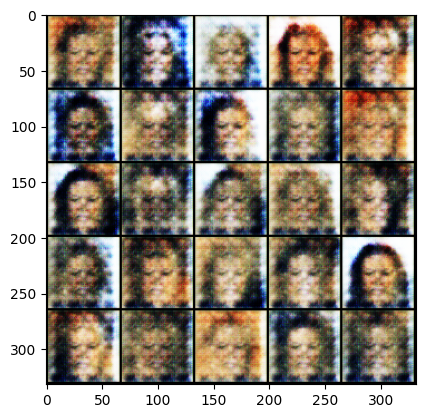

In [ ]:
noise = torch.randn(batch_size, z_dim, 1, 1, device=device)  # [Generator의 input] random noise 생성
fake_images = gen(noise)    # [Generator] random noise로부터 이미지 생성하기
show_tensor_images(fake_images)  # Generator로 생성한 이미지 화면에 보이기

In [ ]:
# 위에서 구한 noise 하나 뽑아보기
print(f'noise shape: {noise.shape}')  # torch.Size([128(batch_size), 100, 1, 1])

noise0 = noise[0].unsqueeze(0)
print(noise0.squeeze())

noise shape: torch.Size([128, 100, 1, 1])
tensor([ 6.8436e-01, -1.9818e+00,  1.2425e+00,  3.1943e-01,  1.4280e-01,
        -9.6610e-01,  2.1224e-01,  5.2494e-01, -1.5530e+00,  4.8917e-01,
        -6.8700e-01, -2.0321e+00,  2.7285e-01, -8.0960e-01,  1.0389e+00,
        -8.8277e-02, -6.2679e-02,  9.1587e-01, -5.4228e-01,  5.4969e-02,
        -3.2890e-01,  9.3740e-01,  2.2930e-02,  1.8238e-01,  1.7116e-02,
        -5.3533e-01, -2.2281e+00,  6.6793e-01, -1.3388e-01, -1.3063e+00,
         9.5658e-01,  3.3614e-02, -1.2356e+00, -1.4012e+00, -7.4968e-01,
         1.1114e+00,  6.9500e-01, -7.0277e-01, -1.6252e+00, -4.3257e-01,
         1.6184e+00, -1.9513e+00, -5.3971e-01,  5.3674e-01, -2.9169e-01,
        -1.4347e+00,  3.2269e-05, -3.0383e-01,  9.2745e-01,  8.4767e-01,
        -1.3738e+00,  2.7169e-01,  1.2485e+00,  2.2822e-01,  2.9549e-01,
        -5.8341e-01, -2.5699e+00,  1.8959e+00, -7.0910e-01,  2.2346e-01,
        -9.3671e-01,  5.7615e-01,  1.4590e+00,  1.3658e+00,  1.1170e+00,
        -

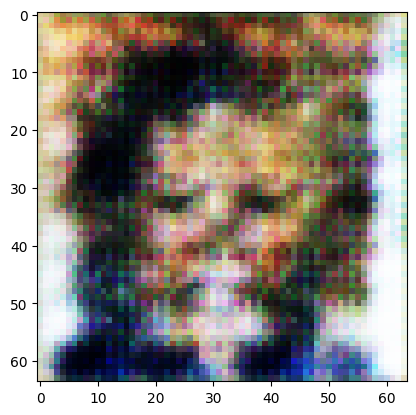

In [ ]:
# 뽑아낸 noise를 통해 generator 가짜 이미지 만들기
gen_fake_images0 = gen(noise0)
show_tensor_images(gen_fake_images0)

# 실습 과제: Interpolation

![ex2](https://user-images.githubusercontent.com/46768752/142652431-9377ac6b-b6d0-4f55-a04a-d2526add011a.png)

- 서로 다른 2개의 random noise vector에 일정한 가중치를 주어 합칠 경우 위와 같은 결과가 나오게 됩니다.
- 임의의 두 이미지를 생성하고, 그 두 이미지 사이에 나타날 수 있는 합성이미지 10개가지를 interpolation을 통해 출력하시오.

* new_noise = $\alpha$ noise_a +  $(1-\alpha)$ noise_b


## (보너스) Linear arithmetic

- 실습 시간이 남는 경우 Linear arithmetic도 구현해보세요.
- 예: vector(안경 낀 남자) - vector(안경 끼지 않은 남자) + vector(안경 끼지 않은 여자) = vector(안경 낀 여자)
- random noise vector값은 각각 영상이 갖고 있는 representation을 나타낸다는 것을 알 수 있습니다.





In [ ]:
########################################

# 여러분의 실습 답안을 이곳에 입력하세요.

#########################################


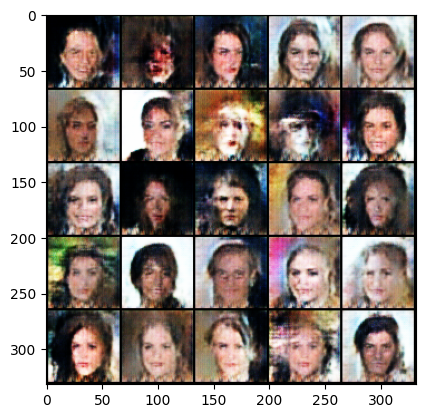

In [ ]:
noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
fake_images = gen(noise)    # [Generator] random noise로부터 이미지 생성하기
show_tensor_images(fake_images)  # Generator로 생성한 이미지 화면에 보이기

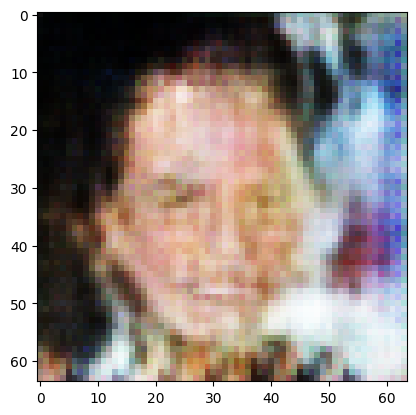

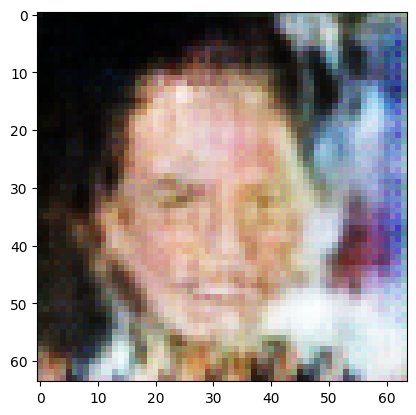

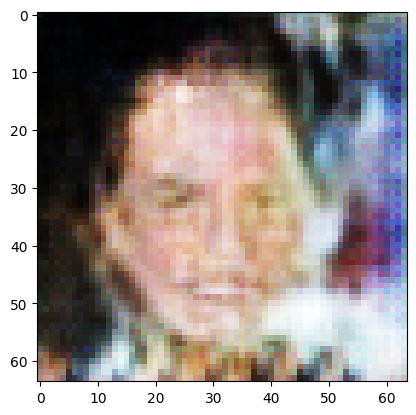

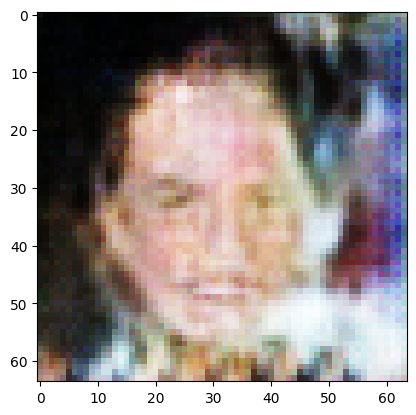

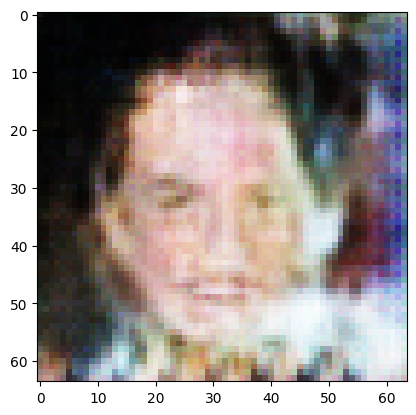

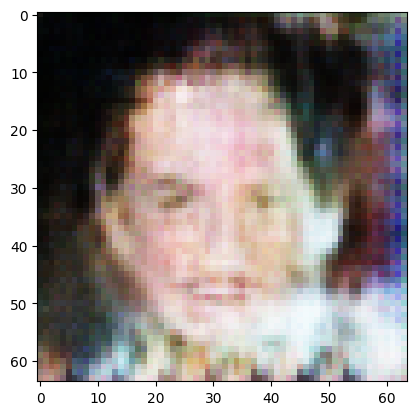

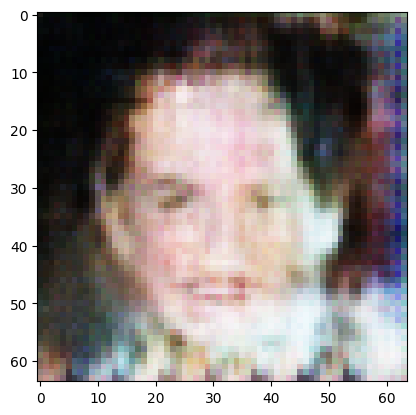

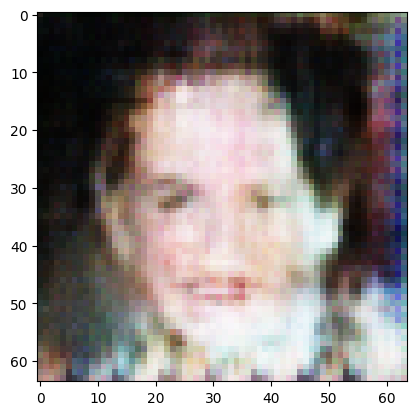

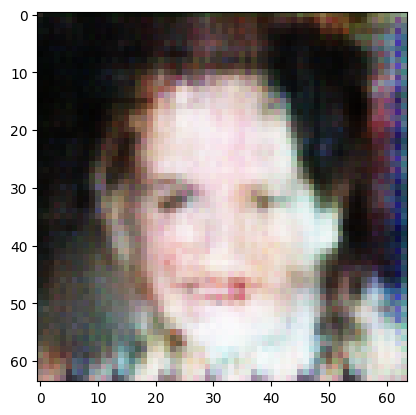

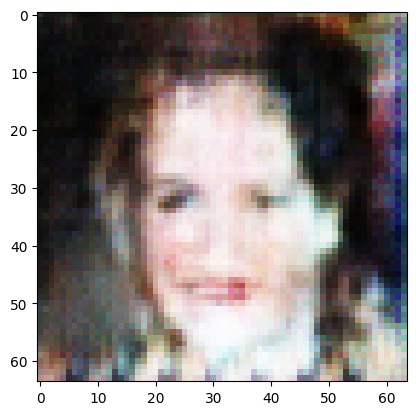

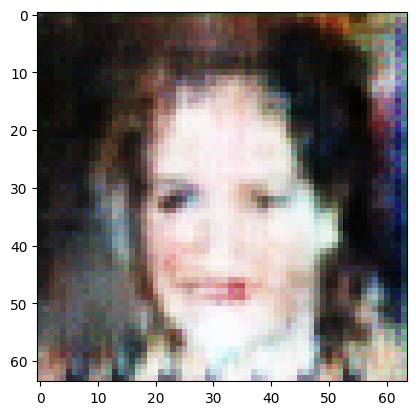

In [ ]:
noise0 = noise[0].unsqueeze(0)
noise1 = noise[21].unsqueeze(0)

for i in range(11):
    new_noise = (10-i)*noise0/10 + i*noise1/10
    new_gen_fake_images = gen(new_noise)
    show_tensor_images(new_gen_fake_images)

# References
[1.] [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)

[2.] [Generative Adversarial Networks (GANs) Specialization](https://www.coursera.org/specializations/generative-adversarial-networks-gans)

[3.] [DCGAN Tutorial - PyTorch Official](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

I would highly recommend [GANs Specialization](https://www.coursera.org/specializations/generative-adversarial-networks-gans) on Coursera if you want to learn GANs in depth.

---

[4.] [DCGAN-라온피플 머신러닝 아카데미] (https://blog.naver.com/PostView.nhn?blogId=laonple&logNo=221201915691)

[5.] [DCGAN 튜토리얼] (https://tutorials.pytorch.kr/beginner/dcgan_faces_tutorial.html)